## Symptom classification EfficientNet

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### Dataset preparation

In [2]:
""" Dataset path """
dataset_path = "//home/rdadmin/Documents/Datasets/Coffee-Datasets/lara2018-master/classifier/dataset/symptom/"
os.path.exists(dataset_path)

True

In [3]:
# imports
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [4]:
train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        ])

eval_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        ])

In [5]:
training_data = ImageFolder(os.path.join(dataset_path,"train"),transform=train_transform)
validation_data = ImageFolder(os.path.join(dataset_path,"val"),transform=eval_transform)
test_data = ImageFolder(os.path.join(dataset_path,"test"),transform=eval_transform)

In [6]:
BATCH_SIZE = 32
train_loader = DataLoader(training_data,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(validation_data,batch_size=BATCH_SIZE,shuffle=False)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

In [7]:
data = next(iter(train_loader))

### EfficientNet module prep

In [8]:
import torch.nn as nn
import torchvision
from torchvision import models

In [9]:
def effnet_b3():
    # load efficientnet b3 ImageNet weights
    model = models.efficientnet_b3(pretrained=True)
    for i,layer in enumerate(model.children()):
        if i == 0:
            for j, param in enumerate(layer.parameters()):
                if j < 300:
                    param.requires_grad = False
                
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3,inplace=True),
        nn.Linear(in_features,5,bias=True),
        nn.Softmax(dim=1)
    )
    
    return model

In [10]:
from datetime import datetime
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score

In [11]:
classes = list(training_data.class_to_idx.values())
y = training_data.targets

In [12]:
# Compute class weights
from sklearn.utils import class_weight
class_weights  = class_weight.compute_class_weight("balanced",classes=classes,y=y)
class_weights = [1, 0.92028986, 0.54899135, 1.07932011, 1.43773585]

In [13]:
# Set devices
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:


class TrainCoffeeSymptomDetection:
    """ Hyperparameters """
    BATCH_SIZE = 32
    LEARNING_RATE = 3e-4
    NUM_EPOCHS = 200

    """ Temp values"""
    BEST_VAL_LOSS = float("inf")
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    best_epoch = 0
    
    def __init__(self):
        pass

    def train_model(self):
        # Load data
        model = effnet_b3()
        # load model and choose device
        model.to(device)

        """ Training loop """
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights,device=device,dtype=torch.float32))
        optimizer = optim.Adam(model.parameters(),lr=self.LEARNING_RATE)
        # Learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.1,patience=5,verbose=True)

        for epoch in range(self.NUM_EPOCHS):
            train_loader = DataLoader(training_data,batch_size=BATCH_SIZE,shuffle=True)
            
            epoch_train_loss = []
            epoch_val_loss = []
        
            epoch_train_F1 = []
            epoch_val_F1 = []

            epoch_train_acc = []
            epoch_val_acc = []
            
            model.train()
            # Create a progress bar
            loop = tqdm(enumerate(train_loader),total=len(train_loader))
            
            # Train on the training set
            for batch_idx,data in loop:
                image,target = data
    
                image = image.to(device)
                target = target.to(device)
                
                preds = model(image)
             
                loss = criterion(preds,target)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step() 
                #preds = torch.softmax(preds,dim=1)
                preds = torch.argmax(preds,dim=1)
                
                acc = accuracy_score(preds.detach().cpu().numpy(),target.detach().cpu().numpy())
                f1 = f1_score(preds.detach().cpu().numpy(),target.detach().cpu().numpy(),average="weighted")
                
                epoch_train_loss.append(loss.detach().item())
                epoch_train_acc.append(acc)
                epoch_train_F1.append(f1)

                loop.set_description(f"Epoch {epoch+1}/{self.NUM_EPOCHS}")
                
                loop.set_postfix(loss=np.array(epoch_train_loss).mean(),
                                    acc = np.array(epoch_train_acc).mean(),
                                    f1 = np.array(epoch_train_F1).mean())
                loop.update()
            # Test on the validation set
            model.eval()
            with torch.no_grad():
                eval_loop = tqdm(enumerate(val_loader),total=len(val_loader))
                for i,data in eval_loop:

                    image,target = data
                    image = image.to(device)
                    target = target.to(device)
                
                    preds = model(image)

                    loss = criterion(preds,target)
                    epoch_val_loss.append(loss.detach().item())
                    
                    #preds = torch.softmax(preds,dim=1)
                    preds = torch.argmax(preds,dim=1)
                    
                    acc = accuracy_score(preds.detach().cpu().numpy(),target.detach().cpu().numpy())
                    f1 = f1_score(preds.detach().cpu().numpy(),target.detach().cpu().numpy(),average="weighted")
                    #recall = recall_score(preds.detach().cpu().numpy(),labels.detach().cpu().numpy(),average="weighted",zero_division=0)
                
                    epoch_val_loss.append(loss.detach().item())
                    epoch_val_acc.append(acc)
                    epoch_val_F1.append(f1)

                    eval_loop.set_description(f"Validation")

                    eval_loop.set_postfix(val_loss=np.array(epoch_val_loss).mean(),
                                            va_acc = np.array(epoch_val_acc).mean(),
                                            va_f1 = np.array(epoch_val_F1).mean())
                    eval_loop.update()
        
            avg_vloss = np.mean(epoch_val_loss)
            scheduler.step(torch.mean(torch.tensor(epoch_val_loss),dtype=torch.float))
            
            
            if self.early_stopping(avg_vloss,patience=10,model=model,epoch=epoch):
                break


    def early_stopping(self,val_loss,patience=5,min_delta=0.01,model=None,epoch=0):
        """ Early stopping """
        if self.BEST_VAL_LOSS - val_loss > min_delta:
            model_path = f"/home/rdadmin/Documents/Fraol-Projects/AIC_Coffee_Disease_DL/classifier_weights/effnet_classifier_{self.timestamp}.pth"
            print(f"val_loss improved from {self.BEST_VAL_LOSS} to {val_loss}, saving model to: {model_path}")
            self.BEST_VAL_LOSS = val_loss
            torch.save(model.state_dict(),model_path)
            self.best_epoch = epoch
            return False

        if epoch - self.best_epoch > patience:
            print(f"Early stopping at epoch {epoch}")
            print(f"Stopped!!!")
            return True
        return False


if __name__ == "__main__":
    TrainCoffeeSymptomDetection().train_model()

/home/rdadmin/miniconda3/envs/torch_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rdadmin/miniconda3/envs/torch_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Validation: 100%|████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.62it/s, va_acc=0.917, va_f1=0.879, val_loss=1.05]


val_loss improved from inf to 1.046172375862415, saving model to: /home/rdadmin/Documents/Fraol-Projects/AIC_Coffee_Disease_DL/classifier_weights/effnet_classifier_20230306_071507.pth


Validation: 100%|███████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.80it/s, va_acc=0.921, va_f1=0.885, val_loss=0.989]


val_loss improved from 1.046172375862415 to 0.9885035432302035, saving model to: /home/rdadmin/Documents/Fraol-Projects/AIC_Coffee_Disease_DL/classifier_weights/effnet_classifier_20230306_071507.pth


Validation: 100%|███████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.49it/s, va_acc=0.927, va_f1=0.893, val_loss=0.973]


val_loss improved from 0.9885035432302035 to 0.9729503163924584, saving model to: /home/rdadmin/Documents/Fraol-Projects/AIC_Coffee_Disease_DL/classifier_weights/effnet_classifier_20230306_071507.pth


Validation: 100%|███████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.78it/s, va_acc=0.944, va_f1=0.917, val_loss=0.959]


val_loss improved from 0.9729503163924584 to 0.9592429261941177, saving model to: /home/rdadmin/Documents/Fraol-Projects/AIC_Coffee_Disease_DL/classifier_weights/effnet_classifier_20230306_071507.pth


Validation: 100%|███████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.70it/s, va_acc=0.944, va_f1=0.918, val_loss=0.962]


Epoch 00012: reducing learning rate of group 0 to 3.0000e-05.


Validation: 100%|███████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.83it/s, va_acc=0.951, va_f1=0.928, val_loss=0.957]

Early stopping at epoch 16
Stopped!!!


### Evaluation

In [20]:
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [30]:
@torch.no_grad()
def evaluate(model,dataloader):
    true_labels = []
    pred_labels = []
    probablities = []
    progress_bar = tqdm(enumerate(dataloader),total=len(dataloader),desc='Evaluating')
    model.eval()
    for i,data in progress_bar:
        image,target = data

        image = image.to(device)
        target = target.to(device)
    
        preds = model(image)

        true_labels += target.tolist()
        probablities += preds.tolist()
  
        preds = torch.argmax(preds,dim=1)
        
        pred_labels += preds.tolist()

    return true_labels,pred_labels,probablities
    

In [31]:
model = effnet_b3()
model.to(device)
model.load_state_dict(torch.load("/home/rdadmin/Documents/Fraol-Projects/AIC_Coffee_Disease_DL/classifier_weights/effnet_classifier_20230306_071507.pth",map_location=device))

/home/rdadmin/miniconda3/envs/torch_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rdadmin/miniconda3/envs/torch_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [32]:
Y_true,y_pred,prob = evaluate(model,test_loader)

Evaluating: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  7.60it/s]


In [33]:
print(classification_report(Y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       0.93      0.92      0.93        90
           2       0.98      0.97      0.98       149
           3       0.95      0.95      0.95        75
           4       0.88      0.91      0.90        57

    accuracy                           0.95       409
   macro avg       0.95      0.95      0.95       409
weighted avg       0.95      0.95      0.95       409



<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

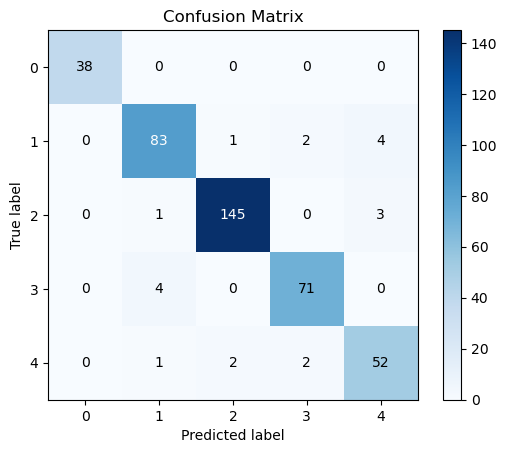

In [34]:
plot_confusion_matrix(Y_true,y_pred)

### Quantize and export as pytorch lite

In [37]:
dummy_input = torch.randn(1,3,224,224,device=device)

In [38]:
coffeenet_torchscript = torch.jit.trace(model,dummy_input)

In [39]:
#Then optimize the TorchScript formatted model for mobile and save it:
from torch.utils.mobile_optimizer import optimize_for_mobile
coffeenet_torchscript_optimized = optimize_for_mobile(coffeenet_torchscript)
torch.jit.save(coffeenet_torchscript_optimized, "coffeenet_quantized.pt")